# Spiral Problem

This is a fictici problem of learning the legnth of a spiral, we use this problem as a proof of concept in a publication:
"*Local Interpretation Methods to Machine Learning Using the Domain of the Feature Space*"

The equation of the features $x_1$ and $x_2$ and target is given by:
$$
x_1 = \theta cos(\theta) + \epsilon_1 \quad x_2 = \theta = \theta sin(\theta) + e2
$$
$$
y = \frac{1}{2}\left[ \theta\sqrt{1+\theta^2} + sinh^{-1} \theta\right]
$$
where $x_1$ and $x_2$ are the values that form the feature vector $x = (x_1, x_2)^\intercal$, $\theta$ is an independent
variable, $\epsilon_1$ and $\epsilon_2$ are random noise variables, and the target value is given by $y$, the length of the spiral. This toy model presents some interesting features for our analysis, such as the feature domain over the spiral and the substantial variance of the target value when varying one of the features coordinate while keeping the other one fixed.

In [2]:
import sys
sys.path.append('../..')
from sklearn.datasets import load_boston
import sklearn.ensemble
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

from playground.aux.domain import Spiral
import lime.lime_tabular
from m_lime.lime_tabular_manifold import LimeTabularExplainerManifold

from sklearn.linear_model import HuberRegressor as Linear
# from sklearn.linear_model import SGDRegressor as Linear

/home/fhv/anaconda3/envs/dm20/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.kde module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# Data spiral

In [2]:
data = Spiral(n_samples=10000, theta_domain=[2*np.pi, 2.5*np.pi], error_x=0.3)

In [3]:
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(data.data, data.target, train_size=0.80)

In [4]:
df = pd.DataFrame(data.data, columns=data.feature_names)

# Training a Random Forrest Model

In [5]:
rf = sklearn.ensemble.RandomForestRegressor(n_estimators=10)
rf.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [6]:
print('Random Forest MSError', np.mean((rf.predict(x_test) - y_test) ** 2))
print('MSError when predicting the mean', np.mean((y_train.mean() - y_test) ** 2))

Random Forest MSError 0.13560429346002445
MSError when predicting the mean 541.4887773603983


# Explanation - Interpretation

In [7]:
categorical_features = np.argwhere(np.array([len(set(data.data[:,x])) for x in range(data.data.shape[1])]) <= 10).flatten()

In [8]:
categorical_features

array([], dtype=int64)

## Explanation for instance x<sup>1</sup> = (0.0, 8.5):

In [9]:
x_explain = np.array([0.0, 8.0])

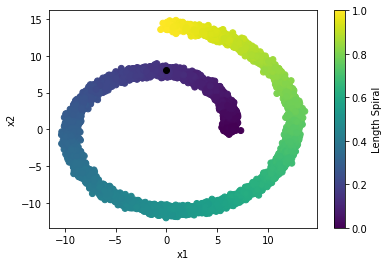

In [10]:
fig, ax = data.plot()
cp = ax.scatter(x_explain[0], x_explain[1], c='black')
color = plt.colorbar(cp, label='Length Spiral')

### Normal Lime

In [11]:
explainer = lime.lime_tabular.LimeTabularExplainer(x_train, feature_names=data.feature_names
        , class_names=['price'], categorical_features=categorical_features, verbose=True, mode='regression')

In [12]:
exp = explainer.explain_instance(x_explain, rf.predict, num_features=5,  model_regressor=Linear())

Intercept 55.455555822217704
Prediction_local [74.24874412]
Right: 32.53149588493988


The Prediction_local and Right do not agree, which decrease trust in the interpretation produced.

In [13]:
exp.show_in_notebook(show_table=True)

This explanation is not correct, as we can see the x<sub>2</sub> is given as the more important. Addionally, we can see that the model do not obtain good fedelidy with the original model.

## Density KDE Lime

Now, we use Kernel Density Estimation (KDE) to estimate the manifold of our feature space. Using this estimation, we sample data in the neigbordhood of the point that we want to explain.

In [14]:
explainer_mani = LimeTabularExplainerManifold(x_train, sample_around_instance=True, manifold='kde'
    , feature_names=data.feature_names, class_names=['price'], categorical_features=categorical_features
    , verbose=True, mode='regression', discretize_continuous=False, manifold_params={'search_best':False})

In [15]:
exp_mani = explainer_mani.explain_instance_manifold(
    x_explain, rf.predict, num_features=5
    , r_density=0.1, model_regressor=Linear(), scale_data=False)

Intercept 31.791987933719547
Prediction_local [32.45697217]
Right: 32.53149588493988


In [16]:
exp_mani.show_in_notebook(show_table=True)

#### Visualization of the sampled data:

In [17]:
fig, ax = data.plot()
cp = ax.scatter(explainer_mani.data[:, 0], explainer_mani.data[:, 1], s=1, c='gray', alpha=0.4)
cp = ax.scatter(x_explain[0], x_explain[1], c='black')

## Density kde-kpca Explantion

In [18]:
explainer_manifold = LimeTabularExplainerManifold(
    x_train, sample_around_instance=True, manifold='kde-kpca'
    , feature_names=['x1', 'x2'], class_names='y'
    , categorical_features=categorical_features, verbose=True, mode='regression'
    , discretize_continuous=False)

Best Parameter for the KDE:
{'bandwidth': 0.01}
Score: -626.0643151446709


In [19]:
exp_manifold = explainer_manifold.explain_instance_manifold(
    x_explain, rf.predict, num_features=2, r_density=0.5, scale_data=False, model_regressor=Linear())

Intercept 0.5010070368868486
Prediction_local [32.53149588]
Right: 32.53149588493988


In [20]:
exp_manifold.show_in_notebook(show_table=True)

In [21]:
fig, ax = data.plot()
cp = ax.scatter(explainer_manifold.data[:, 0], explainer_mani.data[:, 1], s=1, c='gray', alpha=0.4)
cp = ax.scatter(x_explain[0], x_explain[1], c='black')

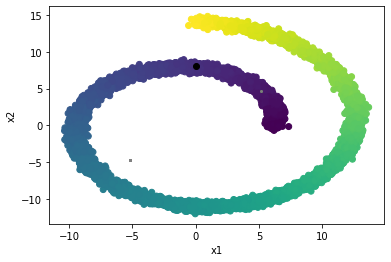

In [22]:
fig, ax = data.plot()
ax.scatter(explainer_manifold.data[:, 0], explainer_manifold.data[:, 1], s=1, c='gray', alpha=0.4)
ax.scatter(x_explain[0], x_explain[1], c='black')

In [23]:
from sklearn.linear_model import HuberRegressor as Linear
# HuberRegressor, LinearRegression, SGDRegressor
def plot_local_predictions_(explainer_manifold, x_explain, rf):
    model_linear = Linear()
    print(x_explain)
    x_sample = explainer_manifold.data
    scaled_x_sample = (x_sample - explainer_manifold.scaler.mean_) / explainer_manifold.scaler.scale_
    y_p = rf.predict(x_sample)
    y_sample = np.empty(y_p.shape[0]) 
#     print('class to explain:', y_explain_index)
    y_sample = y_p  #[:, y_explain_index]

    scaled_var = False
    if scaled_var:
        model_linear.fit(scaled_x_sample, y_sample)
        y_linear = model_linear.predict(scaled_x_sample)
    else:
        model_linear.fit(x_sample, y_sample)
        y_linear = model_linear.predict(x_sample)

    importance = model_linear.coef_.reshape(-1)
    print('>>>>>>>>>>>>>>', model_linear.predict(x_explain.reshape(1, -1)))
    print(data.feature_names)
    print(importance)
    fig, axis = plt.subplots(1, 4, figsize=(15, 5))
    for j in range(x_sample.shape[1]):
        x_j = x_sample[:, j]
        axis[j].scatter(x_j, y_sample)
        axis[j].scatter(x_j, y_linear, s=1)
        axis[j].set_xlabel(data.feature_names[j])
    plot_prediction_sampling(rf, explainer_manifold)

In [24]:
def plot_density_target():
    classes_predicted_unique = np.unique(df_train['predicted'].values)
    columns = list(data.feature_names)
    fig, axis = plt.subplots(1, 4, figsize=(20, 5))
    axis = axis.reshape(-1)
    for i, (ax, col_i) in enumerate(zip(axis, columns)):
        for class_i in classes_predicted_unique:

            subset = df_train[df_train['predicted']==class_i]
            sns.distplot(subset[col_i], hist = False, kde = True,
                     kde_kws = {'shade': True, 'linewidth': 3}, 
                      label = class_i, ax=ax)
            ax.axvline(x=x_explain[i], c='red')
        ax.set_xlabel(col_i, )
    plt.show()

    # from itertools import permutations
    # from sklearn.neighbors import KernelDensity

    # cols_per = permutations(columns, 2)
    # for i, (col_1, col_2) in enumerate(cols_per):
    #     if i == len(columns):
    #         break
    #     cs = plt.contourf(h, #levels=[10, 30, 50],
    #     extend='both', cmap='coolwarm')
    #     cs.cmap.set_over('red')
    #     cs.cmap.set_under('blue')
    #     cs.changed()
    #     plt.colorbar(cs)
    
def plot_prediction_sampling(rf, explainer_manifold):
    y_p = rf.predict_proba(explainer_manifold.data)
    axis = None
    for class_i in classes_predicted_unique:
        subset = df_train[df_train['predicted']==class_i]
        if axis is None:
            axis = explainer_manifold.plot(subset[data.feature_names].values, figsize=(15, 15), alpha=0.6)
        else:    
            explainer_manifold.plot(subset[data.feature_names].values, axis, alpha=0.6)

    # explainer_manifold.plot(df_train[data.feature_names].values, axis)
    for i in range(4):
        for j in range(4):
            if i==j:
                pass
            else:
                x = explainer_manifold.data[:, j]
                y = explainer_manifold.data[:, i]
                cp = axis[i, j].scatter(x, y, edgecolors='none', c=y_p[:, y_explain_index].reshape(-1), alpha=1.0, cmap='brg', s=1)

    axis = explainer_manifold.plot(x_explain.reshape(1, -1), axis)            
    plt.colorbar(cp)